In [28]:
import os
import pandas as pd
import numpy as np

In [30]:
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder

## Load data

In [33]:
for file_name in os.listdir("files"):
    if file_name.endswith('.csv'):
        file_path = os.path.join("files", file_name)

        df_name = os.path.splitext(file_name)[0]
        globals()[df_name] = pd.read_csv(file_path)


In [35]:
#dfs with missing data: learn_dataset_job, learn_dataset_retired_jobs, test_dataset_job, test_dataset_retired_jobs

## Simplification of categories

In [38]:
# sports
learn_dataset_sport = pd.merge(learn_dataset_sport, code_Sports, left_on="Sports", right_on="Code")
learn_dataset_sport["Sports_Category"] = learn_dataset_sport["Categorie"]
learn_sports = learn_dataset_sport[["PRIMARY_KEY", "Sports_Category"]]

# departments into regions
def merge_and_extract_region(df, merge_column, region_column_name):
    df = pd.merge(df, departments, left_on=merge_column, right_on="DEP")
    df[region_column_name] = df["REG"]
    df.drop(["Nom du département", "REG", "DEP", merge_column], axis=1, inplace=True)
    return df

learn_dataset_job = merge_and_extract_region(
    learn_dataset_job, merge_column="JOB_DEP", region_column_name="REG_JOB"
)

learn_dataset_retired_jobs = merge_and_extract_region(
    learn_dataset_retired_jobs, merge_column="JOB_DEP", region_column_name="REG_JOB"
)

learn_dataset_retired_jobs = merge_and_extract_region(
    learn_dataset_retired_jobs, merge_column="FORMER_DEP", region_column_name="REG_FORMER"
)

#loc = pd.merge(city_adm, departments, on="DEP", how="left")
#INSEE_REG = loc[["INSEE_CODE", "REG"]]

In [40]:
#Economic sector into fewer categories (and numeric instead of object/string)
def sector_mapping(nace_code):
    if nace_code == "AZ":  
        return "Agriculture, forestry and fishing)"
    elif "BZ" <= nace_code <= "EZ":
        return "Manufacturing, mining and quarrying and other industrial activities"
    elif nace_code == "FZ": 
        return "Construction"
    elif "GZ" <= nace_code <= "IZ":  
        return "Wholesale and retail trade, transportation and storage, accommodation and food service activities"
    elif "JA" <= nace_code <= "JC":
        return "Information and communication"
    elif nace_code == "KZ": 
        return "Financial and insurance activities"
    elif nace_code == "LZ": 
        return "Real estate activities"
    elif "MA" <= nace_code <= "NZ":
        return "Professional, scientific, technical, administrative and support service activities"
    elif "OZ" <= nace_code <= "QB":
        return "Public administration and defence, education, human health and social work activities"
    elif "RZ" <= nace_code <= "UZ":
        return "Other services activities"
    else:
        return "Unknown Sector"

code_Economic_sector["Nomenclature"] = code_Economic_sector["Code"].map(sector_mapping)
code_Economic_sector["Economic_sector_num"] = pd.factorize(code_Economic_sector["Nomenclature"])[0] + 1

code_emp_contract["emp_contract_num"] = pd.factorize(code_emp_contract["Code"])[0] + 1
code_HIGHEST_CREDENTIAL["HIGHEST_CREDENTIAL_num"] = pd.factorize(code_HIGHEST_CREDENTIAL["Code"])[0] + 1
code_act["act_num"] = pd.factorize(code_act["Code"])[0] + 1

learn_dataset_emp_contract = pd.merge(learn_dataset_emp_contract, code_emp_contract, left_on="emp_contract",  right_on="Code")
learn_dataset_emp_contract.drop(["Code", "Libellé"], axis=1, inplace=True)

## Merging

In [43]:
learn_data = learn_dataset
learn_data = learn_data[['target'] + [col for col in learn_data.columns if col != 'target']]

learn_data = pd.merge(learn_data, code_act, left_on="act", right_on="Code", how="left")
learn_data.drop(["Code", "Libellé"], axis=1, inplace=True)
learn_data = pd.merge(learn_data, code_HIGHEST_CREDENTIAL, left_on="HIGHEST_CREDENTIAL", right_on="Code", how="left")
learn_data.drop(["Code", "Libellé", "HIGHEST_CREDENTIAL"], axis=1, inplace=True)

#learn_data = pd.merge(learn_data, INSEE_REG, on="INSEE_CODE", how="left")
learn_data = pd.merge(learn_data, city_pop, on="INSEE_CODE", how="left")

In [45]:
learn_dfs = [learn_sports, learn_dataset_emp_contract, learn_dataset_job, learn_dataset_retired_former, learn_dataset_retired_jobs, learn_dataset_retired_pension]

for df in learn_dfs:
    learn_data = pd.merge(learn_data, df, on="PRIMARY_KEY", how="outer")

In [47]:
def combine_columns(col_x, col_y):
    return col_x.fillna(col_y) if col_y is not None else col_x

for column in learn_data.columns:
    if column.endswith('_x'):
        base_column = column[:-2]  # Remove `_x` suffix
        y_column = base_column + '_y'
        if y_column in learn_data.columns:
            # Combine the columns
            learn_data[base_column] = combine_columns(learn_data[column], learn_data[y_column])
            # Drop the original `_x` and `_y` columns
            learn_data = learn_data.drop(columns=[column, y_column])


## Formatting

In [50]:
learn_data = pd.merge(learn_data, code_Economic_sector, left_on="Economic_sector", right_on="Code", how="left")

learn_data = pd.merge(learn_data, code_work_description_map, left_on="work_description", right_on="N3", how="left")
learn_data.drop(["work_description", "N3", "N2"], axis=1, inplace=True)
learn_data["N1"] = learn_data["N1"].str.extract(r'csp_(\d)')[0].astype("Int64")
learn_data.rename(columns={"N1": "work_description"}, inplace=True)

#learn_data["emp_contract"] = combine_columns(learn_data["emp_contract"], learn_data["former_emp_contract"])
learn_data["Pay"] = combine_columns(learn_data["Pay"], learn_data["RETIREMENT_PAY"])

learn_data["Employer_category"] = learn_data["Employer_category"].str.extract(r'ct_(\d)')[0].astype("Int64")
learn_data["employee_count"] = learn_data["employee_count"].str.extract(r'tr_(\d)')[0].astype("Int64")


In [52]:
learn_data["JOB_42"] = learn_data["JOB_42"].str.extract(r'csp_(\d+)_')[0].astype(int)
learn_data["FORMER_JOB_42"] = learn_data["FORMER_JOB_42"].str.extract(r'csp_(\d+)_')[0].astype("Int64")

learn_data['is_retired'] = (learn_data['JOB_42'] == 7).astype(int)
learn_data['is_employed'] = (learn_data['act'] == 'TACT1_1').astype(int)

# Replace retired JOB_42 with their old JOB_42 categories
learn_data.loc[learn_data['JOB_42'] == 7, 'JOB_42'] = learn_data['FORMER_JOB_42']

# Replace REG_JOB with REG values where REG_JOB is NaN ???
#learn_data.loc[learn_data['REG_JOB'].isna(), 'REG_JOB'] = learn_data.loc[learn_data['REG_JOB'].isna(), 'REG']

learn_data['is_unemployed'] = (
    (learn_data['act'].str.startswith('TACT2_') & (learn_data['act'] != 'TACT2_1')) | 
    (learn_data['JOB_42'] == 8) | (learn_data['act'] == 'TACT1_2')
).astype(int)

learn_data['unemployed_or_na'] = (
    (learn_data['act'].str.startswith('TACT2_') & (learn_data['act'] != 'TACT2_1')) | 
    (learn_data['JOB_42'] == 8) | 
    (learn_data['act'] == 'TACT1_2') | 
    (learn_data['WORK_CONDITION'].isna())
).astype(int)

In [54]:
learn_data.drop(columns=["former_emp_contract", "RETIREMENT_PAY", "FORMER_JOB_42", "emp_contract", "act", "Economic_sector", "Code", "Libellé", "Nomenclature"], inplace=True)
#or keep nomenclature, remove economic_sector_num

In [56]:
# types
learn_data["sex"] = pd.factorize(learn_data["sex"])[0]
learn_data["studying"] = learn_data["studying"].astype("int64")
learn_data["Sports_Category"] = learn_data["Sports_Category"].fillna(0).astype("int64")
#or learn_data["Sports_Category"] = pd.to_numeric(learn_data["Sports_Category"], errors='coerce').astype("Int64")
learn_data["emp_contract_num"] = pd.to_numeric(learn_data["emp_contract_num"], errors='coerce').astype('Int64')
learn_data["REG_JOB"] = pd.to_numeric(learn_data["REG_JOB"], errors='coerce').astype('Int64')
learn_data["REG_FORMER"] = pd.to_numeric(learn_data["REG_FORMER"], errors='coerce').astype('Int64')
learn_data["retirement_age"] = pd.to_numeric(learn_data["retirement_age"], errors='coerce').astype('Int64')
learn_data["WORKING_HOURS"] = pd.to_numeric(learn_data["WORKING_HOURS"], errors='coerce').astype('Int64')
learn_data["Economic_sector_num"] = pd.to_numeric(learn_data["Economic_sector_num"], errors='coerce').astype('Int64')

In [58]:
def household_num(value):
    parts = value.split('|')  # Split the value by '|'
    if parts[1] in {'1', '2', '3'}:  # For M|1|-- to M|3|--
        return int(parts[1])
    elif parts[1] == '4':  # For M|4|1 to M|4|4
        return 4 + (int(parts[2]) - 1)  # 4 + (1-1), 4 + (2-1), etc.
    return None  # Handle unexpected cases gracefully

code_HOUSEHOLD_TYPE['HOUSEHOLD_TYPE_num'] = code_HOUSEHOLD_TYPE['Code'].apply(household_num)
learn_data['HOUSEHOLD_TYPE'] = learn_data['HOUSEHOLD_TYPE'].apply(household_num)


consider making pay categorical as well with eg tax level boundaries?

check main against job type against full job

do one-hot-encoding for WORK_CONDITION, TYPE_OF_CONTRACT, labor_force_status

put all in one dataset, but with dummies for those with more data

link dep to INSEE code for missing ones - only missing for those who have other missing data
-- instead of INSEE_CODE use region? then we get current living region, job region, and former region.

for all now numerical cats but with missing values, can do +1 and make fillna as 0

note: TACT2_3 doesn't exist in dataset - no under 14 year olds

In [61]:
learn_data.dtypes #maybe working hours?, retirement age, (retirement) pay, should be int64

target                    float64
PRIMARY_KEY                 int64
sex                         int64
JOB_42                      int64
studying                    int64
INSEE_CODE                 object
age_2020                    int64
HOUSEHOLD_TYPE              int64
act_num                     int64
HIGHEST_CREDENTIAL_num      int64
RESIDENTS                   int64
Sports_Category             int64
emp_contract_num            Int64
Pay                       float64
retirement_age              Int64
REG_FORMER                  Int64
Employer_category           Int64
employee_count              Int64
TYPE_OF_CONTRACT           object
WORK_CONDITION             object
labor_force_status         object
WORKING_HOURS               Int64
REG_JOB                     Int64
Economic_sector_num         Int64
work_description            Int64
is_retired                  int64
is_employed                 int64
is_unemployed               int64
unemployed_or_na            int64
dtype: object

## Split for visualisation - ignore this for now

### Employed

In [65]:
# DataFrame for those who are neither retired nor unemployed
employed = learn_data[(learn_data['is_retired'] == 0) & (learn_data['unemployed_or_na'] == 0)]
employed = employed.dropna(axis=1, how='all')
employed.drop(columns=["is_retired", "is_unemployed", "unemployed_or_na", "is_employed"], inplace=True)

### Retired

In [68]:
# DataFrame for those who are retired
retired = learn_data[(learn_data['is_retired'] == 1) & (learn_data['unemployed_or_na'] == 0)]
#retired = learn_data[learn_data['is_retired'] == 1]
retired = retired.dropna(axis=1, how='all')
retired.drop(columns=["is_retired", "is_unemployed", "unemployed_or_na", "is_employed"], inplace=True)

### Other (unemployed)

In [74]:
unemployed_or_other = learn_data[learn_data['unemployed_or_na'] == 1]
unemployed_or_other = unemployed_or_other.dropna(axis=1, how='all')
unemployed_or_other['is_employed'] = unemployed_or_other['emp_contract_num'].notna().astype(int)
unemployed_or_other.drop(columns=["is_unemployed"], inplace=True)

I'm confused about the people who have a JOB_42 that implies employment, but an act that implies the opposite - maybe just currently jobless but searching?

should the rows with full missing data be in this df as well?

make dummy for those without any extra info and exclude them in these splits?
(2449 ppl from retired and 4878 from employed)

33 ppl have emp_contract 2-3 which means non-salaries aide familiaux but theyr have tact1-1 Actifs ayant un emploi, y compris sous apprentissage ou en stage rémunéré. --conflict? wrong emp_contract?

in new version of unemployed & other, remove pay, ret_age, and emp_contract? keep dummies instead - make dummy for employed for those who had emp_contract


redo the is_unemplyed into is_employed from the top

change is_unemployed to 'other'

# Handling Missing Data

In [78]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

print(missing_values_table(learn_data)) 

There are 13 columns that have missing values.
                     Missing Values  % of Total Values
REG_FORMER                    39169               78.3
retirement_age                36720               73.4
emp_contract_num              26050               52.1
Employer_category             21413               42.8
employee_count                21225               42.4
WORKING_HOURS                 20072               40.1
TYPE_OF_CONTRACT              20054               40.1
WORK_CONDITION                20054               40.1
labor_force_status            20054               40.1
REG_JOB                       20054               40.1
Economic_sector_num           20054               40.1
work_description              20054               40.1
Pay                           19688               39.3


In [34]:
# for job_42 cats csp_1 and 2 have emp_contract but missing data for all other job stuff
# and for csp_8 have missing data for all job stuff 


### FOR employee_count

In [37]:
#no longer necessary? - employee count now numerical
le = preprocessing.LabelEncoder()
le.fit(learn_data.loc[:,"employee_count"])
dict(zip(le.classes_, le.transform(le.classes_)))

{0.0: 0, 1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4, 5.0: 5, 6.0: 6, nan: 7}

In [42]:
learn_data['employee_count_encoded'] = le.transform(learn_data['employee_count'])
learn_data['employee_count_encoded'] = learn_data['employee_count_encoded'].map(lambda x: np.nan if x==7 else x)
df_train = learn_data.loc[:,["PRIMARY_KEY", "employee_count_encoded","studying", "WORKING_HOURS", "age_2020","Pay", "retirement_age",
                             "Sports_Category", "REG_JOB","REG_FORMER"]]
df_train.head()

,PRIMARY_KEY,employee_count_encoded,studying,WORKING_HOURS,age_2020,Pay,retirement_age,Sports_Category,REG_JOB,REG_FORMER
0,1,1.0,0,1470,34,17011.0,<NA>,1,84,<NA>
1,5,1.0,0,793,80,17598.0,60,<NA>,44,44
2,7,NaN,0,<NA>,63,NaN,<NA>,<NA>,<NA>,<NA>
3,8,1.0,0,1201,50,57220.0,<NA>,<NA>,11,<NA>
4,10,NaN,0,<NA>,68,NaN,<NA>,<NA>,<NA>,<NA>


In [44]:
#imputer = IterativeImputer(random_state=100)
#imputer.fit(df_train)
#df_imputed = imputer.transform(df_train)
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
knn_imputer.fit(df_train)
df_imputed = knn_imputer.transform(df_train)

In [45]:
learn_data.loc[:,"employee_count_encoded"] = df_imputed[:,1].round()
count_imputed = list(le.inverse_transform(learn_data['employee_count_encoded'].round().astype('int')))
learn_data["employee_count_encoded"] = count_imputed

In [116]:
learn_data.dtypes

target                    float64
PRIMARY_KEY                 int64
sex                         int64
JOB_42                      int64
studying                    int64
INSEE_CODE                 object
age_2020                    int64
HOUSEHOLD_TYPE              int64
act_num                     int64
HIGHEST_CREDENTIAL_num      int64
RESIDENTS                   int64
Sports_Category             int64
emp_contract_num            Int64
Pay                       float64
retirement_age              Int64
REG_FORMER                  Int64
Employer_category           Int64
employee_count              Int64
TYPE_OF_CONTRACT           object
WORK_CONDITION             object
labor_force_status         object
WORKING_HOURS               Int64
REG_JOB                     Int64
Economic_sector_num         Int64
work_description            Int64
is_retired                  int64
is_employed                 int64
is_unemployed               int64
unemployed_or_na            int64
dtype: object

## ML - to do

In [138]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_score, GridSearchCV


In [164]:
#drop residents col before this? and insee code just for now bc its still object
a = learn_data.drop(columns=['RESIDENTS', 'INSEE_CODE'])
a = pd.get_dummies(a)


In [174]:
# Split data into features and target
##Don't forget to edit the col ranges after editing types and stuff later
X_train = a.drop(columns=['target'])
y_train = a['target']

basic_cols = list(X_train.columns[:8]) + ['is_employed', 'is_retired']
employed_cols = list(X_train.columns[:10]) + list(X_train.columns[13:18]) + list(X_train.columns[23:])
retired_cols = list(X_train.columns[:8]) + list(X_train.columns[10:18]) + list(X_train.columns[23:])

# Create masks for the different subsets
basic_mask = X_train[list(X_train.columns[:9]) + ['is_employed', 'is_retired']].notna().all(axis=1)
employed_mask = X_train[list(X_train.columns[:11]) + list(X_train.columns[14:22])].notna().all(axis=1)
retired_mask = X_train[list(X_train.columns[:9]) + list(X_train.columns[11:22])].notna().all(axis=1)

In [176]:
#reformat the train test split section
# Simple Model: Basic features
X_basic = X_train.loc[basic_mask, basic_cols]
y_basic = y_train.loc[basic_mask]


In [178]:
X_train_basic, X_test_basic, y_train_basic, y_test_basic = train_test_split(X_basic, y_basic, test_size=0.2, random_state=42)
basic_model = RandomForestRegressor(random_state=42)
basic_model.fit(X_train_basic, y_train_basic)
y_pred_basic = basic_model.predict(X_test_basic)


In [179]:
cross_val_rmse = cross_val_score(basic_model, X_train_basic, y_train_basic, cv=10, scoring='neg_root_mean_squared_error')
rmse_test = root_mean_squared_error(y_test_basic, y_pred_basic)

print("RMSE on the learning set:", -cross_val_rmse.mean())
print("RMSE on the test set: ", rmse_test)

RMSE on the learning set: 1.206431140912477
RMSE on the test set:  1.2081427019157915


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


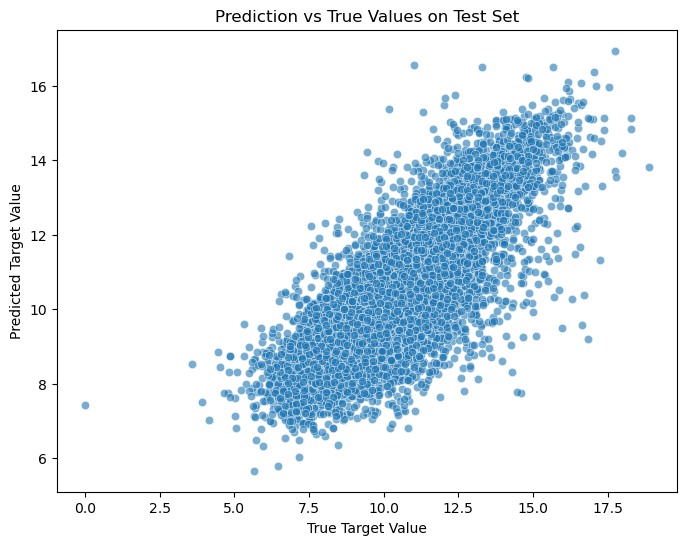

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_basic, y=y_pred_basic, alpha=0.6)
plt.xlabel('True Target Value')
plt.ylabel('Predicted Target Value')
plt.title('Prediction vs True Values on Test Set')
plt.show()

In [181]:

# Model including Employed details
X_employed = X_train.loc[employed_mask, employed_cols]
y_employed = y_train.loc[employed_mask]
X_train_employed, X_test_employed, y_train_employed, y_test_employed = train_test_split(X_employed, y_employed, test_size=0.2, random_state=42)
employed_model = RandomForestRegressor(random_state=42)
employed_model.fit(X_train_employed, y_train_employed)
y_pred_employed = employed_model.predict(X_test_employed)

# Model for Retired details
X_retired = X_train.loc[retired_mask, retired_cols]
y_retired = y_train.loc[retired_mask]
X_train_retired, X_test_retired, y_train_retired, y_test_retired = train_test_split(X_retired, y_retired, test_size=0.2, random_state=42)
retired_model = RandomForestRegressor(random_state=42)
retired_model.fit(X_train_retired, y_train_retired)
y_pred_retired = retired_model.predict(X_test_retired)


In [186]:
# Complex Model: Combining predictions - doesn't look right??
complex_X = pd.DataFrame(index=X_train.index)  # Ensure all rows in X_train are included

# Add predictions, aligning rows and filling missing predictions with NaN initially
complex_X['Simple_Model'] = pd.Series(basic_model.predict(X_train.loc[basic_mask, basic_cols]), index=X_train.loc[basic_mask].index)
complex_X['Employed_Model'] = pd.Series(employed_model.predict(X_train.loc[employed_mask, employed_cols]), index=X_train.loc[employed_mask].index)
complex_X['Retired_Model'] = pd.Series(retired_model.predict(X_train.loc[retired_mask, retired_cols]), index=X_train.loc[retired_mask].index)

complex_y = y_train.loc[basic_mask | employed_mask | retired_mask]
X_train_complex, X_test_complex, y_train_complex, y_test_complex = train_test_split(complex_X, complex_y, test_size=0.2, random_state=42)
complex_model = RandomForestRegressor(random_state=42)
complex_model.fit(X_train_complex, y_train_complex)
y_pred_complex = complex_model.predict(X_test_complex)


In [192]:
# Evaluation
print("Simple Model RMSE:", root_mean_squared_error(y_test_basic, y_pred_basic))
print("Employed Model RMSE:", root_mean_squared_error(y_test_employed, y_pred_employed))
print("Retired Model RMSE:", root_mean_squared_error(y_test_retired, y_pred_retired))
print("Complex Model RMSE:", root_mean_squared_error(y_test_complex, y_pred_complex))


Simple Model RMSE: 1.2081427019157915
Employed Model RMSE: 1.0917786510067207
Retired Model RMSE: 1.0330691817337732
Complex Model RMSE: 1.2431796540227233


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


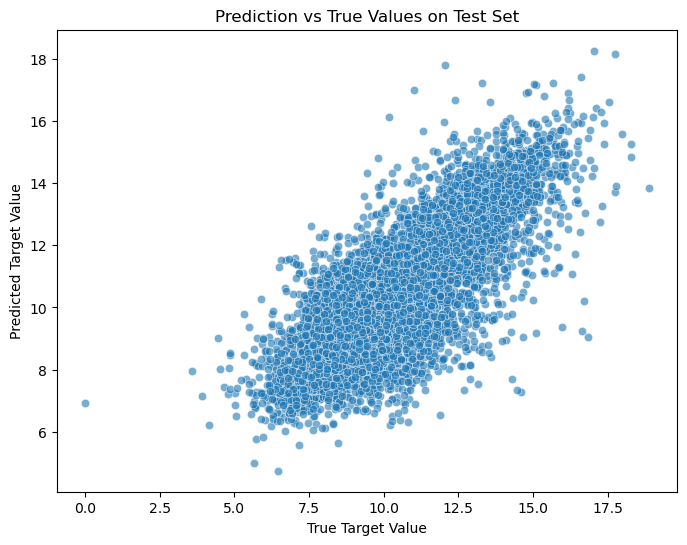

In [190]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_complex, y=y_pred_complex, alpha=0.6)
plt.xlabel('True Target Value')
plt.ylabel('Predicted Target Value')
plt.title('Prediction vs True Values on Test Set')
plt.show()